In [1]:
import numpy as np
import matplotlib.pyplot as plt

# try to use numba to speed up the code, if not installed, comment this line and the @jit decorator below
from numba import jit   

%matplotlib inline

In [147]:
### generate X,Y,Z coordinates of particles (characteristics) X,Y,Z \in [0,1)
X = ...
Y = ...
Z = ...

In [148]:
@jit(nopython=True)
def cic_deposit_3d( X, Y, Z, ngrid ):
  """Tri-linear interpolation of particles to grid

  Args:
      X (ndarray): x-coordinates of particles
      Y (ndarray): y-coordinates of particles
      Z (ndarray): z-coordinates of particles
      ngrid (int): number of grid points along one dimension

  Returns:
      ndarray: density contrast field
  """
  assert len(X) == len(Y) == len(Z), "X,Y,Z must have the same length"
  rho = np.zeros((ngrid,ngrid,ngrid)) 
  w = 1/len(X) # weight of each particle
  for x,y,z in zip(X,Y,Z):
    x = np.fmod(1.0+x,1.0)
    y = np.fmod(1.0+y,1.0)
    z = np.fmod(1.0+z,1.0)
    
    il = int(np.floor(x*ngrid))
    ir = (il+1)%ngrid
    jl = int(np.floor(y*ngrid))
    jr = (jl+1)%ngrid
    kl = int(np.floor(z*ngrid))
    kr = (kl+1)%ngrid
    dx = x*ngrid-float(il)
    dy = y*ngrid-float(jl)
    dz = z*ngrid-float(kl)
    rho[il,jl,kl] += (1-dx)*(1-dy)*(1-dz)
    rho[il,jr,kl] += (1-dx)*dy*(1-dz)
    rho[ir,jl,kl] += dx*(1-dy)*(1-dz)
    rho[ir,jr,kl] += dx*dy*(1-dz)
    rho[il,jl,kr] += (1-dx)*(1-dy)*dz
    rho[il,jr,kr] += (1-dx)*dy*dz
    rho[ir,jl,kr] += dx*(1-dy)*dz
    rho[ir,jr,kr] += dx*dy*dz
    # rhomean = len(X)/ngrid**3
  rhomean = np.mean(rho.flatten())
  return rho/rhomean - 1

In [161]:
# create a 3D grid of density contrast by interpolating particles
nres = 128
delta = cic_deposit_3d(xvec[0,...].flatten(),xvec[1,...].flatten(),xvec[2,...].flatten(),nres)

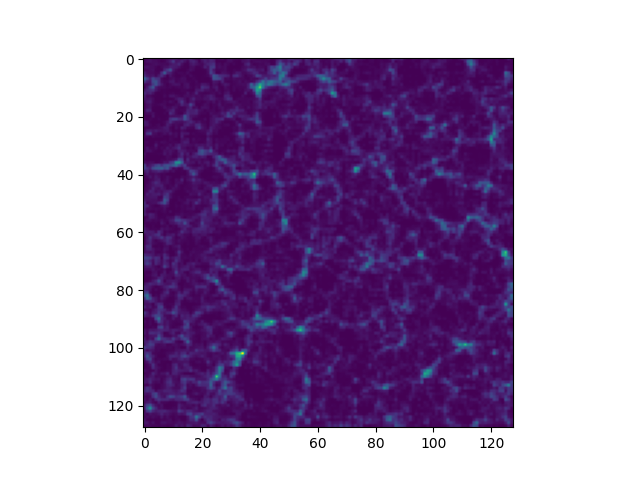

In [162]:
# visualize a slice of the grid
fig, ax = plt.subplots()
ax.imshow( delta[:,:,nres//2] )

In [163]:
def compute_powerspectrum( f, L=1.0 ):
  """Compute the isotropic power spectrum of a 3d field, note 
     that the spectrum estimate is not corrected for a possible interpolation function

  Args:
      f (ndarray): input field
      L (float): linear box size (default: 1.0)
  Returns:
      ndarray: k values
      ndarray: power spectrum P(k) = 1/(2π)^3 |delta_k|^2
  """
  N = f.shape[0]
  assert (f.shape[1] == f.shape[0]) and (f.shape[2] == f.shape[0]), "Input field must be cubic"
  assert len(f.shape) == 3, "Input field must be 3D"

  # set up wave numbers (this is the same code as in the GRF generation)
  twopi = 2.0*np.pi
  kmin = twopi/L                             # the fundamental mode of the box
  kmax = kmin * N/2                          # the Nyquist mode of each linear dimension
  k1d = np.fft.fftfreq(N,d=1.0/kmin/N)       # get a 1D vector with all values of 'k'
  kv = np.meshgrid(k1d,k1d,k1d) # turn this into 3 3D fields giving kx,ky,kz for each point
  kmod = np.sqrt(kv[0]**2+kv[1]**2+kv[2]**2) # get norm k for each point

  # compute the power spectrum P(k) = 1/(2π)^3 |delta_k|^2
  P = np.abs( np.fft.fftn(f)/N**3 )**2 
  
  ## compute isotropic average, to do this we average over shells in k-space, i.e.
  ## P_iso(k) = <P(m)>_{||m||=k}, where <.> denotes average over k-space shells, i.e. k < ||m|| < k+dk
  # get bin for each mode 
  kmodes = np.linspace(kmin,kmax,num=N//2)  # set up the shell radii
  ibin = np.digitize(kmod.flat,kmodes)      # determine which shell each mode is in
  # compute average power in each shell
  Pavg = np.bincount(ibin,weights=P.flat)[1:-1]/np.bincount(ibin)[1:-1]
  
  kmid = 0.5*(kmodes[1:]+kmodes[:-1])       # get the k value at the centre of each shell
  return kmid, Pavg * L**3                  # multiply by L^3 to get P(k) in correct units if L is not 1.0



In [164]:
# measure the power spectrum of the density contrast field
km,Pm = compute_powerspectrum(delta)

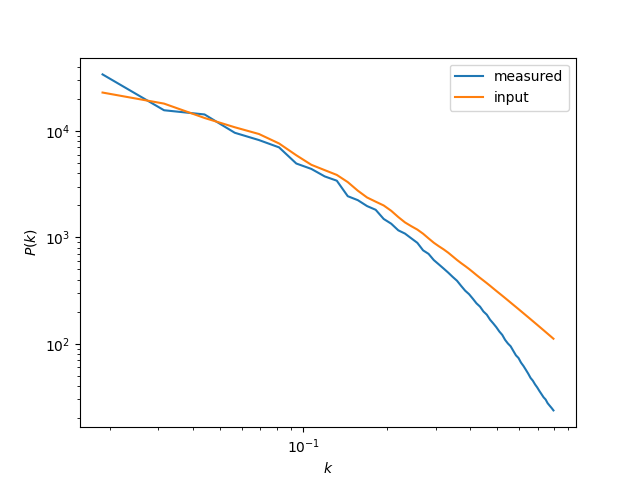

In [167]:
fig, ax = plt.subplots()
ax.loglog(km,Pm,label='measured')
# ax.loglog(kinput,Pinput),label='input') # plot the input power spectrum for comparison
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$P(k)$')

ax.legend()